In [0]:
import pandas as pd 
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn import decomposition
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture 


### Dataset

The dataset consists of a csv file and it has 4 columns:
- one with the id
- one with the poem text
- one with some tags related to the poem
- the poet

The number of rows in the csv file is 13854. The poets and tags columns can not be used as labels for the poems.

Number of poets:3128

Number of unique tags: 8298



In [4]:
dataFrame = pd.read_csv('PoetryFoundationData.csv')
print('Number of rows in the csv file: ',len(dataFrame))
print('Number of poets: ',len(dataFrame.Poet.unique()))
print('Number of unique tags: ', len(dataFrame.Tags.unique()))
dataFrame = dataFrame.dropna(subset=['Tags'])

Number of rows in the csv file:  13854
Number of poets:  3128
Number of unique tags:  8298


In [0]:
poems = dataFrame['Poem']
tags = dataFrame['Tags']

In [6]:
poems

6        \r\r\nInvisible fish swim this ghost ocean now...
7        \r\r\nDon’t bother the earth spirit who lives ...
9        \r\r\nHour in which I consider hydrangea, a sa...
16       \r\r\nmy father’s body is a map\r\r\na record ...
17       \r\r\nit has long been forgotten this practice...
                               ...                        
13835    \r\r\nDear Writers, I’m compiling the first in...
13848    \r\r\nThe Wise Men will unlearn your name.\r\r...
13849    \r\r\nWe'd  like  to  talk  with  you  about  ...
13852    \r\r\n          Philosophic\r\r\nin its comple...
13853    \r\r\nDear Writers, I’m compiling the first in...
Name: Poem, Length: 12899, dtype: object

### Data preprocessing

Because is about poems in this dataset, all the characters which are not letters have been removed from the poems and tags columns.
Further, a list of hardcoded stopwords have been used to eliminate the english common words from the poems.After that, a corpus was created which contains words from poems and tags columns.


In [0]:
charactersToBeReplaced = '[^a-zA-Z]+'
for i in range(len(poems)):
    poems.values[i]=re.sub(charactersToBeReplaced," ",poems.values[i])
for i in range(len(poems)):
    tags.values[i]=re.sub(charactersToBeReplaced," ",tags.values[i])


In [7]:
print(len(tags),len(poems))

12899 12899


In [0]:
stopwords = ['a','about','above','across','after','afterwards','again','against','all','almost','alone','along','already','also','although','always','am','among','amongst','amoungst','amount','an','and','another','any','anyhow','anyone','anything','anyway','anywhere','are','around','as','at','back','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','below','beside','besides','between','beyond','bill','both','bottom','but','by','call','can','cannot','cant','co','computer','con','could','couldnt','cry','de','describe','detail','do','done','down','due','during','each','eg','eight','either','eleven','else','elsewhere','empty','enough','etc','even','ever','every','everyone','everything','everywhere','except','few','fifteen','fify','fill','find','fire','first','five','for','former','formerly','forty','found','four','from','front','full','further','get','give','go','had','has','hasnt','have','he','hence','her','here','hereafter','hereby','herein','hereupon','hers','herse','him','himse','his','how','however','hundred','i','ie','if','in','inc','indeed','interest','into','is','it','its','keep','last','latter','latterly','least','less','ltd','made','many','may','me','meanwhile','might','mill','mine','more','moreover','most','mostly','move','much','must','my','myse','name','namely','neither','never','nevertheless','next','nine','no','nobody','none','noone','nor','not','nothing','now','nowhere','of','off','often','on','once','one','only','onto','or','other','others','otherwise','our','ours','ourselves','out','over','own','part','per','perhaps','please','put','rather','re','same','see','seem','seemed','seeming','seems','serious','several','she','should','show','side','since','sincere','six','sixty','so','some','somehow','someone','something','sometime','sometimes','somewhere','still','such','system','take','ten','than','that','the','their','them','themselves','then','thence','there','thereafter','thereby','therefore','therein','thereupon','these','they','thick','thin','third','this','those','though','three','through','throughout','thru','thus','to','together','too','top','toward','towards','twelve','twenty','two','un','under','until','up','upon','us','very','via','was','we','well','were','what','whatever','when','whence','whenever','where','whereafter','whereas','whereby','wherein','whereupon','wherever','whether','which','while','whither','who','whoever','whole','whom','whose','why','will','with','within','without','would','yet','you','your','yours','yourself','yourselves']

In [0]:
stemmer = PorterStemmer()
corpus = []
indexToDrop = []
for i,poem in enumerate(poems):
  aux = []
  for word in poem.split(' '):
    stemWord = stemmer.stem(word.lower())
    if stemWord not in stopwords and word.lower() not in stopwords and len(stemWord)>2:
      aux.append(stemWord)
  for word in tags.values[i].split(' '):
    stemWord = stemmer.stem(word.lower())
    if stemWord not in stopwords and word.lower() not in stopwords and len(stemWord)>2:
      aux.append(stemWord)
  if len(aux)>0:
    corpus.append(aux)
  else:
    indexToDrop.append(i)

In [10]:
len(corpus)

12899

In [0]:
corpus1 = [' '.join(poem) for poem in corpus]

The corpus was used to obtain the tfidf matrix with the help of TfidfVectorizer class from gensim package. And with the same corpus, the doc2vec feature matrix was computed using Doc2Vec class.

In [0]:

tfidfVectorizer = TfidfVectorizer(stop_words="english",max_features=50)
tfidfVectorizer.fit(corpus1)
features = tfidfVectorizer.transform(corpus1)

In [0]:
taggedPoems = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(corpus)]
modelDoc2Vec = Doc2Vec(vector_size=50, window=3,epochs=20, min_count=1, workers=4)
modelDoc2Vec.build_vocab(taggedPoems)
modelDoc2Vec.train(taggedPoems,total_examples=modelDoc2Vec.corpus_count,epochs=modelDoc2Vec.epochs)


In [0]:
docsVecs = [modelDoc2Vec.infer_vector(doc) for doc in corpus]

In [15]:
len(docsVecs)

12899

In [0]:
def getDistortions(lowerLimit,upperLimit,features):
  distortions=[]
  silhouette_scores = []
  for i in range(lowerLimit,upperLimit):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(features)
    labels = kmeans.predict(features)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features,labels,metric='euclidean'))
  return distortions,silhouette_scores

## Kmeans with tfidf matrix

In order to find a proper value for the n_clusters hyperparameter of the kmeans algorithm, the distortion value was computed with k in [2,60],but because the plot obtained was not conclusive, the silhouette_score was computed as well and k was chosen for the largest value of the silhouette_score.

In [0]:
tfidf= features.toarray()

In [0]:

distortionsTfidf,silhouette_scores_tfidf = getDistortions(2,60,tfidf)

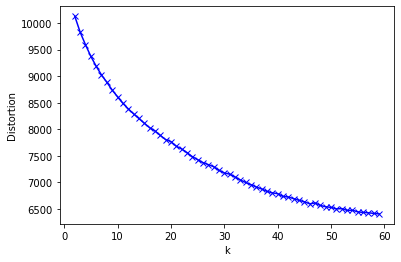

In [19]:
plt.plot(range(2,60), distortionsTfidf, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

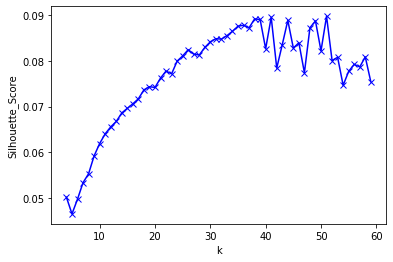

In [20]:
plt.plot(range(4,60), silhouette_scores_tfidf[2:], 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette_Score')
plt.show()

In [0]:
kmeansTfIdf = KMeans(n_clusters=51).fit(tfidf)

In [47]:
labelsTfidfKmeans = kmeansTfIdf.predict(tfidf)
silhouette_score(tfidf, labelsTfidfKmeans, metric='euclidean')

0.08681465983257393

In [0]:
def plotKmeansClusters(kmeanModel,features,labels):
  fig = figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
  ax = fig.gca(projection='3d')
  pca = decomposition.PCA(n_components=3)
  pca.fit(features)
  x3d = pca.transform(features)
  print(pca.explained_variance_ratio_)
  ax.scatter3D(x3d[:, 0], x3d[:, 1], x3d[:,2], c=labels, s=50, cmap='viridis')
  centers = pca.transform(kmeanModel.cluster_centers_)
  ax.scatter3D(centers[:, 0], centers[:, 1],centers[:,2],c='black', s=200, alpha=0.6);
def plotDbscan(features,labels):
  figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
  pca = decomposition.PCA(n_components=2)
  pca.fit(features)
  x2d = pca.transform(features)
  plt.scatter(x2d[:, 0], x2d[:, 1], c=labels, s=50, cmap='viridis')

def plot3D(features,labels):
  fig = figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
  ax = fig.gca(projection='3d')
  pca = decomposition.PCA(n_components=3)
  pca.fit(features)
  x3d = pca.transform(features)
  print(pca.explained_variance_ratio_)
  ax.scatter3D(x3d[:, 0], x3d[:, 1], x3d[:, 2], c=labels, s=50, cmap='viridis')
  

[0.05379413 0.04262333 0.03649516]


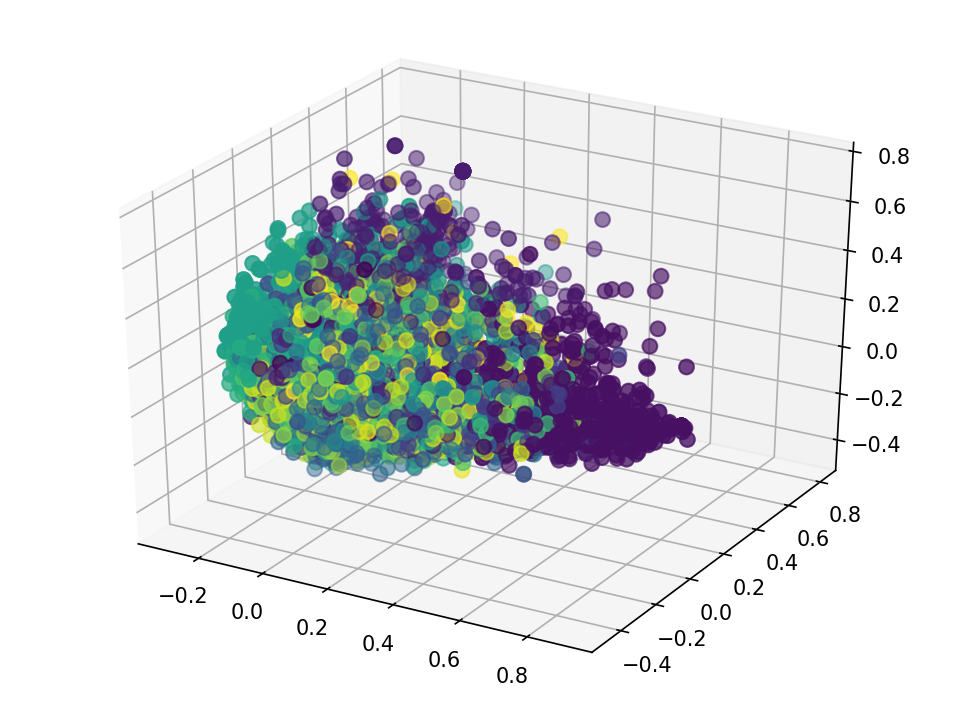

In [67]:
plotKmeansClusters(kmeansTfIdf,tfidf,labelsTfidfKmeans)

For Doc2Vec matrix, 10 clusters were chosen as being the right number of clusters according to the silhouette score and the image bellow.

In [0]:
distortionsDocVecs,silhouette_score_docVecs = getDistortions(2,60,docsVecs)

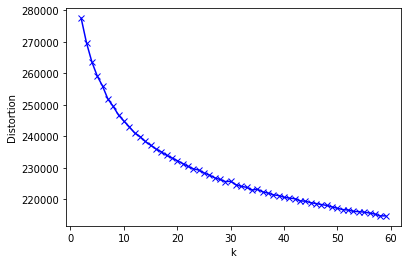

In [51]:
plt.plot(range(2,60), distortionsDocVecs, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [23]:
kmeansDocsVecs = KMeans(n_clusters=10).fit(docsVecs)
labelsDocsVecsKmeans = kmeansDocsVecs.predict(docsVecs)
silhouette_score(docsVecs,labelsDocsVecsKmeans)

0.020423023

[0.11227435 0.05482647 0.04799315]


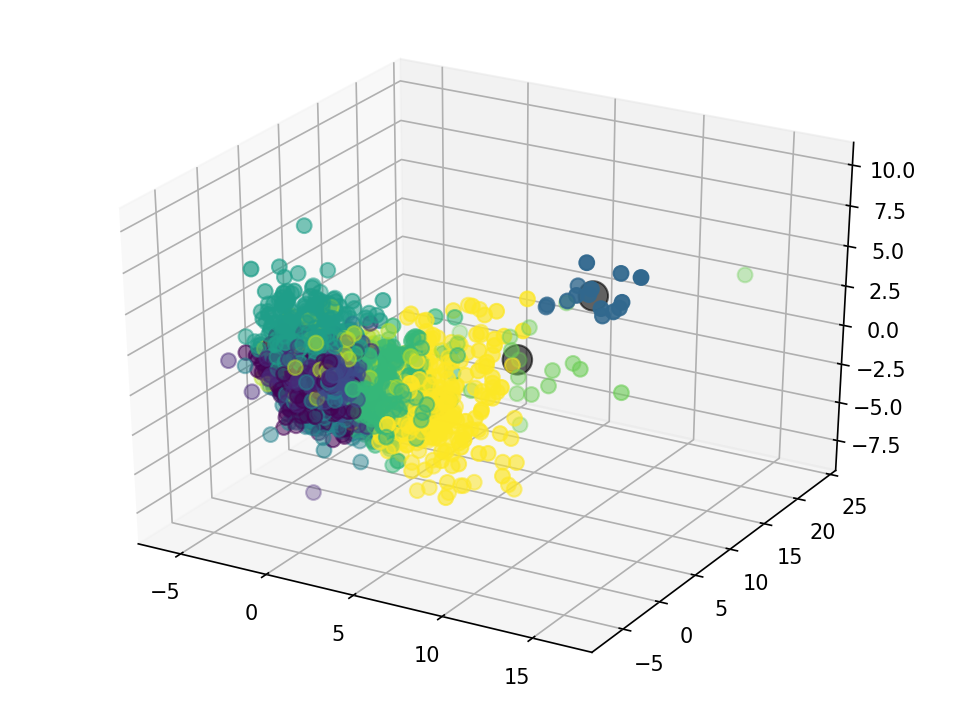

In [68]:
plotKmeansClusters(kmeansDocsVecs,docsVecs,labelsDocsVecsKmeans)

### Dbscan

Ordered the distances from every point to the 200th closest neighbor to found a proper value for eps hyperparameter. For tfidf feature matrix, a strange result was obtained and decided to go with the epsilon value which gives the largest silhouette_Score.
For doc2vec matrix, the eps was assigned to 6.5.

In [0]:
def getDistances(features,noNeighbors):
  nbrs = NearestNeighbors(n_neighbors=noNeighbors, algorithm='ball_tree').fit(features)
  distances, _ = nbrs.kneighbors(features)
  return distances

In [0]:
ks = [200,250,300]
kDistances = []
aux = []
for val in ks:
  aux = getDistances(tfidf,val)[:,val-1]
  sortedIndices = np.argsort(aux)
  kDistances.append(aux[sortedIndices])

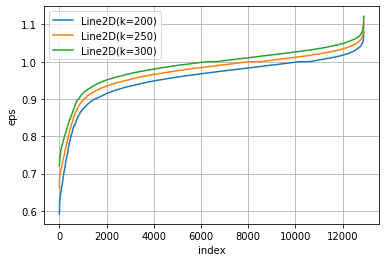

In [56]:
lines = []
for i in range(len(ks)):
  line, = plt.plot(range(0,kDistances[i].shape[0]), kDistances[i], '-',label='k=' + str(ks[i]))
  lines.append(line)
plt.grid()
plt.xlabel('index')
plt.ylabel('eps')
plt.legend(lines)
plt.show()

In [0]:
 dbscanTfIdf = DBSCAN(eps=0.75,min_samples=200)
 dbscanTfIdf = dbscanTfIdf.fit(tfidf)

In [58]:
print(silhouette_score(tfidf,dbscanTfIdf.labels_))
labelsTfIdfDbscan = dbscanTfIdf.labels_

0.03840616359901257


[0.05379409 0.04262325 0.03649714]


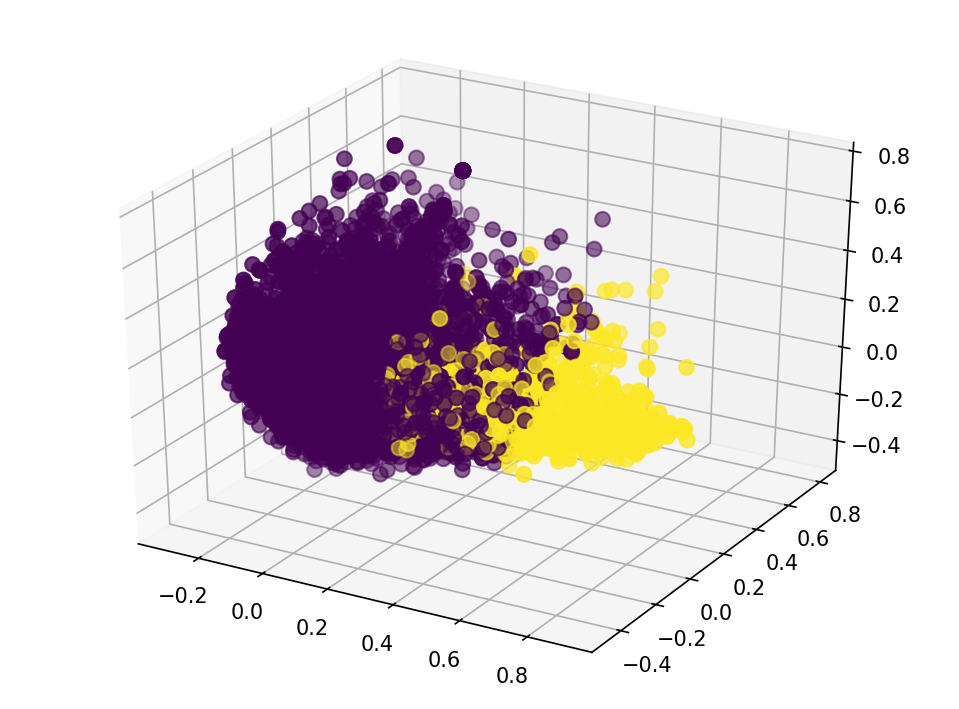

In [69]:
plot3D(tfidf,labelsTfIdfDbscan)

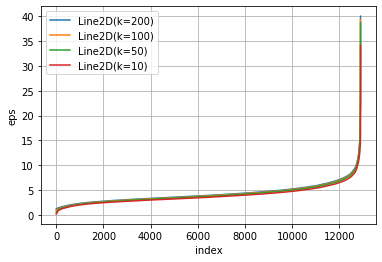

In [60]:
ks = [200,100,50,10]
kDistances = []
aux = []
lines = []
for val in ks:
  aux = getDistances(docsVecs,val)[:,val-1]
  sortedIndices = np.argsort(aux)
  kDistances.append(aux[sortedIndices])
for i in range(len(ks)):
  line, = plt.plot(range(0,kDistances[i].shape[0]), kDistances[i], '-',label='k=' + str(ks[i]))
  lines.append(line)
plt.grid()
plt.xlabel('index')
plt.ylabel('eps')
plt.legend(lines)
plt.show()

According to the image, best value for eps is around 7.


0.6854515
[0.22079182 0.12918786 0.06911152]


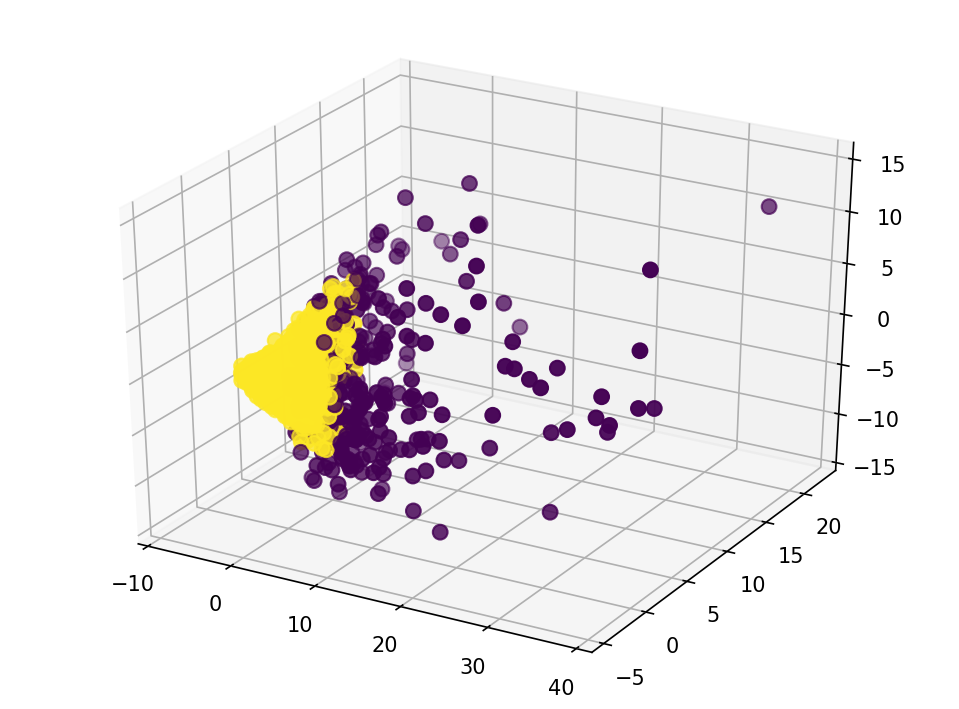

In [22]:
 dbscanDocsVecs = DBSCAN(eps=7,min_samples=200)
 dbscanDocsVecs = dbscanDocsVecs.fit(docsVecs)
 print(silhouette_score(docsVecs,dbscanDocsVecs.labels_))
 labelsDocsVecsDbscan = dbscanDocsVecs.labels_
 plot3D(docsVecs,labelsDocsVecsDbscan)

### Agglomerative Clustering

For this algorithm, the number of components(clusters) must be tuned. To do that, the largest silhouette_score was searched and the adequate k value was used.

If for kmeans the same strategy would have been used then these 2 algorithms would have been labeled the data very similar.

In [0]:
def get_best_AgglomerativeClustering(x):
    best_result = 0.0;
    for i in range(2,50):
            agg = AgglomerativeClustering(n_clusters = i)
            y_pred = agg.fit_predict(x)
            silhouette_value = silhouette_score(x,y_pred)
            if silhouette_value > best_result:
                y = y_pred
                best_result = silhouette_value
                agg_result = agg;
    print(best_result)
    return agg_result;

In [20]:
aggTfIdf = get_best_AgglomerativeClustering(tfidf)

0.045354538819275314


[0.05379401 0.04262313 0.03648242]


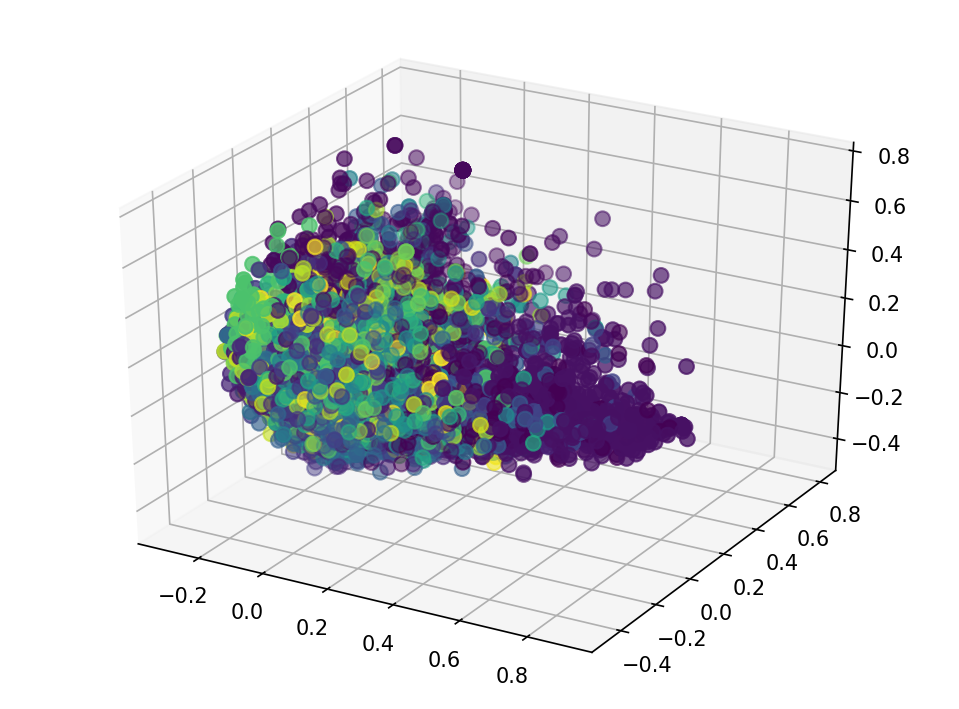

In [76]:
aggTfidfLabels = aggTfIdf.labels_
plot3D(tfidf,aggTfidfLabels)

In [19]:
aggDocsVecs = get_best_AgglomerativeClustering(docsVecs)

0.7099197


[0.11227435 0.05482644 0.04799308]


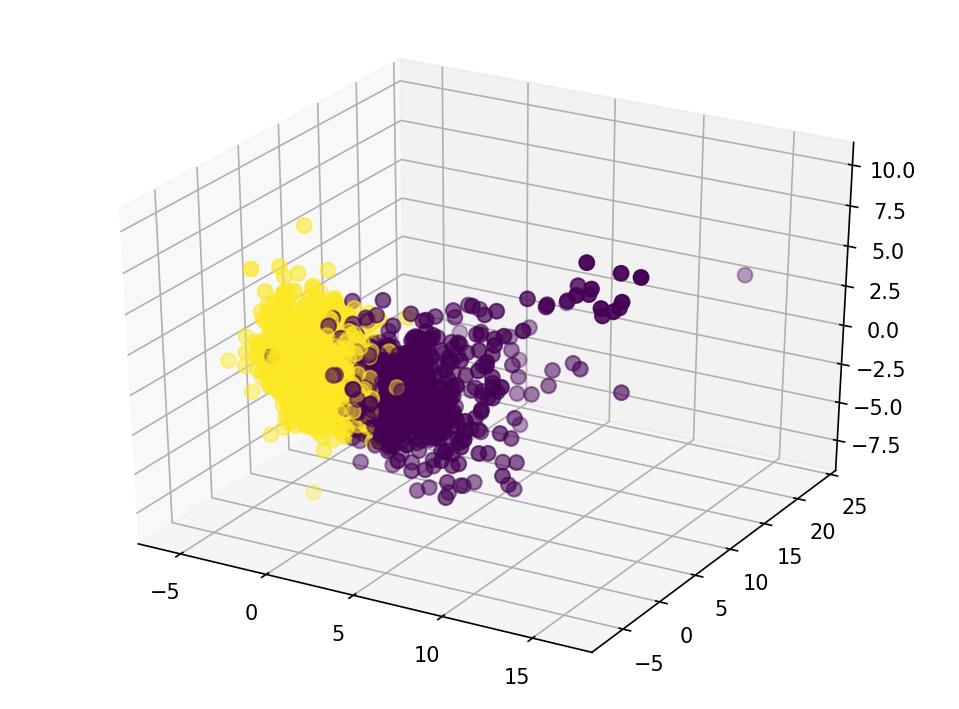

In [74]:
aggDocVecsLabels = aggDocsVecs.labels_
plot3D(docsVecs,aggDocVecsLabels)

In [0]:
dataFrame['KMeans_Tfidf'] = labelsTfidfKmeans
dataFrame['KMeans_DocsVecs'] = labelsDocsVecsKmeans
dataFrame['Dbscan_DocsVecs'] = labelsDocsVecsDbscan
dataFrame['Agglomerative_DocsVecs'] = aggDocVecsLabels
dataFrame['Agglomerative_Tfidf'] = aggTfidfLabels

In [44]:
dataFrame[dataFrame['Dbscan_DocsVecs'] == 8]

,Unnamed: 0,Title,Poem,Poet,Tags,KMeans_DocsVecs,Dbscan_DocsVecs
246,61,"\r\r\nfrom Aurora Leigh, Second Book\r\r\n ...",\r\r\n\r\r\n ...,Elizabeth Barrett Browning,"Relationships,Men & Women,Social Commentaries,...",2,-1
294,109,\r\r\nfrom Rider [II]\r\r\n,\r\r\nAnd yesterday something shattering happe...,Mark Rudman,"Living,Life Choices,Love,Desire,Realistic & Co...",7,-1
304,119,\r\r\n In Memory of My Heav...,"\r\r\nThere goes the\r\r\naluminum, the antimo...",Jeff Derksen,"Living,Coming of Age,The Body",9,-1
327,142,\r\r\n Negative Space\r\r\n...,\r\r\n1.\r\r\nI was born on a Tuesday in April...,Luljeta Lleshanaku,"Living,Coming of Age,Religion,Faith & Doubt,Ar...",7,-1
330,145,\r\r\n Homo Antarcticus\r\r...,"\r\r\n\r\r\n\r\r\n\r\r\n""The wild will keep ca...",Luljeta Lleshanaku,"Living,Death,Nature,Landscapes & Pastorals,Myt...",7,-1
...,...,...,...,...,...,...,...
12702,79,\r\r\n Mac Flecknoe\r\r\n ...,\r\r\n\r\r\n\r\r\n\r\r\nA Satire upon the True...,John Dryden,"Arts & Sciences,Humor & Satire,Poetry & Poets,...",6,-1
12733,110,\r\r\n The Progress of Poes...,"\r\r\nI.1. Awake, Æolian lyre, awake,...",Thomas Gray,"Nature,Landscapes & Pastorals,Arts & Sciences,...",2,-1
12779,156,\r\r\n Hyperion\r\r\n ...,\r\r\n\r\r\n\r\r\n\r\r\n(excerpt)\r\r\n\r\r\n\...,John Keats,"Living,Disappointment & Failure,Nature,Stars, ...",6,-1
12801,178,\r\r\n The Landlord's Tale....,"\r\r\nListen, my children, and you shall hear ...",Henry Wadsworth Longfellow,"Social Commentaries,History & Politics,War & C...",2,-1


In [0]:
df = pd.read_csv('PoetryFoundationData.csv')
df = df[df['Tags'].isnull()]
poems = df['Poem']

In [0]:
charactersToBeReplaced = '[^a-zA-Z]+'
for i in range(len(poems)):
    poems.values[i]=re.sub(charactersToBeReplaced," ",poems.values[i])

In [0]:
stemmer = PorterStemmer()
corpus = []
indexToDrop = []
poems = df['Poem']

for i,poem in enumerate(poems):
  aux = []
  for word in poem.split(' '):
    stemWord = stemmer.stem(word.lower())
    if stemWord not in stopwords and word.lower() not in stopwords and len(stemWord)>2:
      aux.append(stemWord)
  if len(aux)>0:
    corpus.append(aux)
  else:
    indexToDrop.append(i)

In [0]:
corpus1 = [' '.join(poem) for poem in corpus]

In [0]:
testTfIdf = tfidfVectorizer.transform(corpus1)

In [0]:
testVecs = [modelDoc2Vec.infer_vector(doc) for doc in corpus]


In [0]:
df = df.drop(df.index[indexToDrop])

In [0]:
df['KMeans_Tfidf'] = kmeansTfIdf.predict(testTfIdf)
df['KMeans_DocsVecs'] = kmeansDocsVecs.predict(testVecs)

In [86]:
print(silhouette_score(testVecs,df['KMeans_DocsVecs']))
print(silhouette_score(testTfIdf,df['KMeans_Tfidf']))

0.054624762
0.11370701548061951


In [0]:
tfidfTest = []
vecTest = []
for i in range(len(df)):
  poet = df['Poet'].values[i]
  labelTfIdf = df['KMeans_Tfidf'].values[i]
  labelVecs = df['KMeans_DocsVecs'].values[i]
  tfidfTest.append((labelTfIdf in dataFrame[dataFrame['Poet'] == poet]['KMeans_Tfidf'].values) or len(dataFrame[dataFrame['Poet'] == poet]) == 0)
  vecTest.append((labelVecs in dataFrame[dataFrame['Poet'] == poet]['KMeans_DocsVecs'].values) or len(dataFrame[dataFrame['Poet'] == poet]) == 0)

In [88]:
np.sum(vecTest)/len(df)


0.8632286995515696

In [168]:
dataFrame[dataFrame['Dbscan_DocsVecs']==-1]

,Unnamed: 0,Title,Poem,Poet,Tags,KMeans_Tfidf,KMeans_DocsVecs,Dbscan_Tfidf,Dbscan_DocsVecs,Agglomerative_DocsVecs,Agglomerative_Tfidf
95,95,\r\r\nfrom The Black Maria\r\r\n,\r\r\n\r\r\n\r\r\n\r\r\n after Neil d...,Aracelis Girmay,"Stars, Planets, Heavens,Race & Ethnicity",41,0,-1,-1,1,8
133,133,\r\r\n Book Review: The Mou...,\r\r\nSpoiler alert: in this all-but-forgotten...,Craig Morgan Teicher,"Coming of Age,Death,Reading & Books",14,0,0,-1,1,25
139,139,"\r\r\n how to get over [""be...",\r\r\nbe born: black\r\r\nas ants on a chicken...,T'ai Freedom Ford,"Popular Culture,Race & Ethnicity",26,4,-1,-1,1,9
150,150,\r\r\n Deed\r\r\n ...,"\r\r\nLet it finally be Friday, let me drive\r...",Diane Gilliam Fisher,Home Life,23,1,-1,-1,1,9
229,44,\r\r\n Unlegendary Heroes\r...,\r\r\n\r\r\n\r\r\n\r\r\n'Life passes through p...,Mary O'Donnell,"Social Commentaries,Gender & Sexuality,History...",28,4,-1,-1,1,18
...,...,...,...,...,...,...,...,...,...,...,...
13618,27,\r\r\n The Voyage Home\r\r\...,\r\r\n\r\r\n\r\r\n\r\r\nThe social instincts ....,Philip Appleman,"Activities,Travels & Journeys,Nature,Arts & Sc...",31,4,-1,-1,1,29
13619,28,\r\r\n In the Black Camaro\...,"\r\r\nThrough the orange glow of taillights, ...",David Bottoms,"Life Choices,Social Commentaries",38,1,-1,-1,1,5
13624,0,\r\r\n An Xmas Murder\r\r\n...,"\r\r\nHe sits at the table, cloudlight of Marc...",Alfred Corn,"Social Commentaries,Crime & Punishment,Christmas",30,1,-1,-1,1,41
13692,17,\r\r\n Nine-Panel Yaak Rive...,"\r\r\nMidmorning like a deserted room, apparit...",Charles Wright,"Living,Death,Time & Brevity,Nature,Animals,Lan...",12,3,-1,-1,1,5


In [98]:
def calculate_wc(points, assignments):
  sum = 0
  for i,assignment in enumerate(assignments):
      for j,assignment1 in enumerate(assignments):
        if(assignment1 == assignment):
          sum += np.linalg.norm(points[i]-points[j])
  return sum

print(calculate_wc(testVecs, df['KMeans_DocsVecs']))

1053512.7493453622


In [101]:
def calculate_bc(points, assignments):
  sum = 0
  for i,assignment in enumerate(assignments):
      for j,assignment1 in enumerate(assignments):
        if(assignment1 != assignment):
          sum += np.linalg.norm(points[i]-points[j])  
  return sum
print(calculate_bc(testVecs, df['KMeans_DocsVecs']))

3056717.3022215366
